In [1]:
# Parameters
# working_dir = "/nfs/team205/heart/Vitro/TF_selection/foetal_vCM_left_compact-vs-trabeculated_downstream/CO_in-silico-perturbation_papermill"
path_to_oracle_object = "/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM.celloracle.oracle"
path_to_oracle_links = "/nfs/team205/heart/anndata_objects/Foetal/celloracle/foetal_AtrialCM_links.celloracle.links"

# path_to_TFs = 

cell_group_name = "AtrialCM"

path_to_res_dict = f"/nfs/team205/heart/anndata_objects/Foetal/celloracle/{cell_group_name}_in-silico_perturbation_May2025.pkl"
path_to_plots = f"/nfs/team205/heart/anndata_objects/Foetal/celloracle/figures_pm/{cell_group_name}_May2025"

ref: https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

# Import libraries

In [2]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [3]:
import celloracle as co
co.__version__

'0.20.0'

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [5]:
sc.settings.set_figure_params(dpi=120)

# Make out directory

In [6]:
if not os.path.exists(path_to_plots):
    # Create the directory
    os.makedirs(path_to_plots)
    print("Directory created successfully")
else:
    print("Directory already exists")

Directory already exists


# Load oracle object

In [7]:
# Load
oracle = co.load_hdf5(path_to_oracle_object)

In [8]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :5664
Auto-selected k is :141


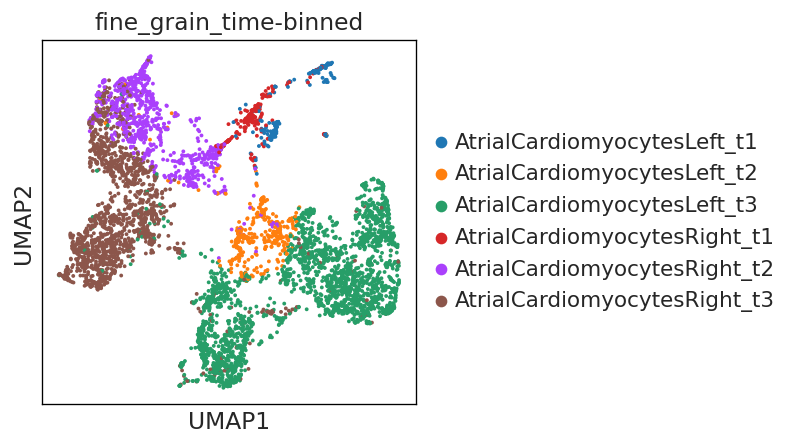

In [9]:
%matplotlib inline
# Check clustering data
sc.pl.umap(oracle.adata, color='fine_grain_time-binned')

# In silico TF perturbation analysis

In [10]:
# read in post-g2g-selection csv file and get selected TFs
# log2FC<0 means TFs specific to Right-aCM
# log2FC>0 means TFs specific to Left-aCM
g2g_sel = pd.read_csv('/nfs/team205/kk18/notebooks/Foetal/AtrialCM_celloracle/AtrialCM_post-g2g_selected-recgulons.csv')
display(g2g_sel)

# TFs, only activator
list_of_TFs = [x.split('_')[0] for x in g2g_sel['Gene'] if '_+' in x]
print(len(list_of_TFs))

,Gene,alignment_similarity_percentage,opt_alignment_cost,l2fc,color,abs_l2fc
0,ETS2_+,0.00,72.073285,-0.687252,red,0.687252
1,MAF_+,21.74,67.731430,-0.555707,red,0.555707
2,IKZF2_+,12.00,70.869309,0.353810,red,0.353810
3,ETV6_+,0.00,72.073285,0.439772,red,0.439772
4,BHLHE41_+,18.52,65.496091,0.450520,red,0.450520
5,GTF2IRD1_+,12.00,63.675774,0.452963,red,0.452963
6,GATA5_+,7.69,72.017812,0.545917,red,0.545917
7,PITX2_+,0.00,72.073285,0.684020,red,0.684020
8,SIX5_extended_+,21.74,61.395848,0.690589,red,0.690589
9,MAF_-,0.00,72.073285,1.296242,red,1.296242


9


In [11]:
# select TFs which are in the oracle object
list_of_TFs = [x for x in list_of_TFs if x in oracle.adata.var_names]

print(len(list_of_TFs))
list_of_TFs[:5]

9


['ETS2', 'MAF', 'IKZF2', 'ETV6', 'BHLHE41']

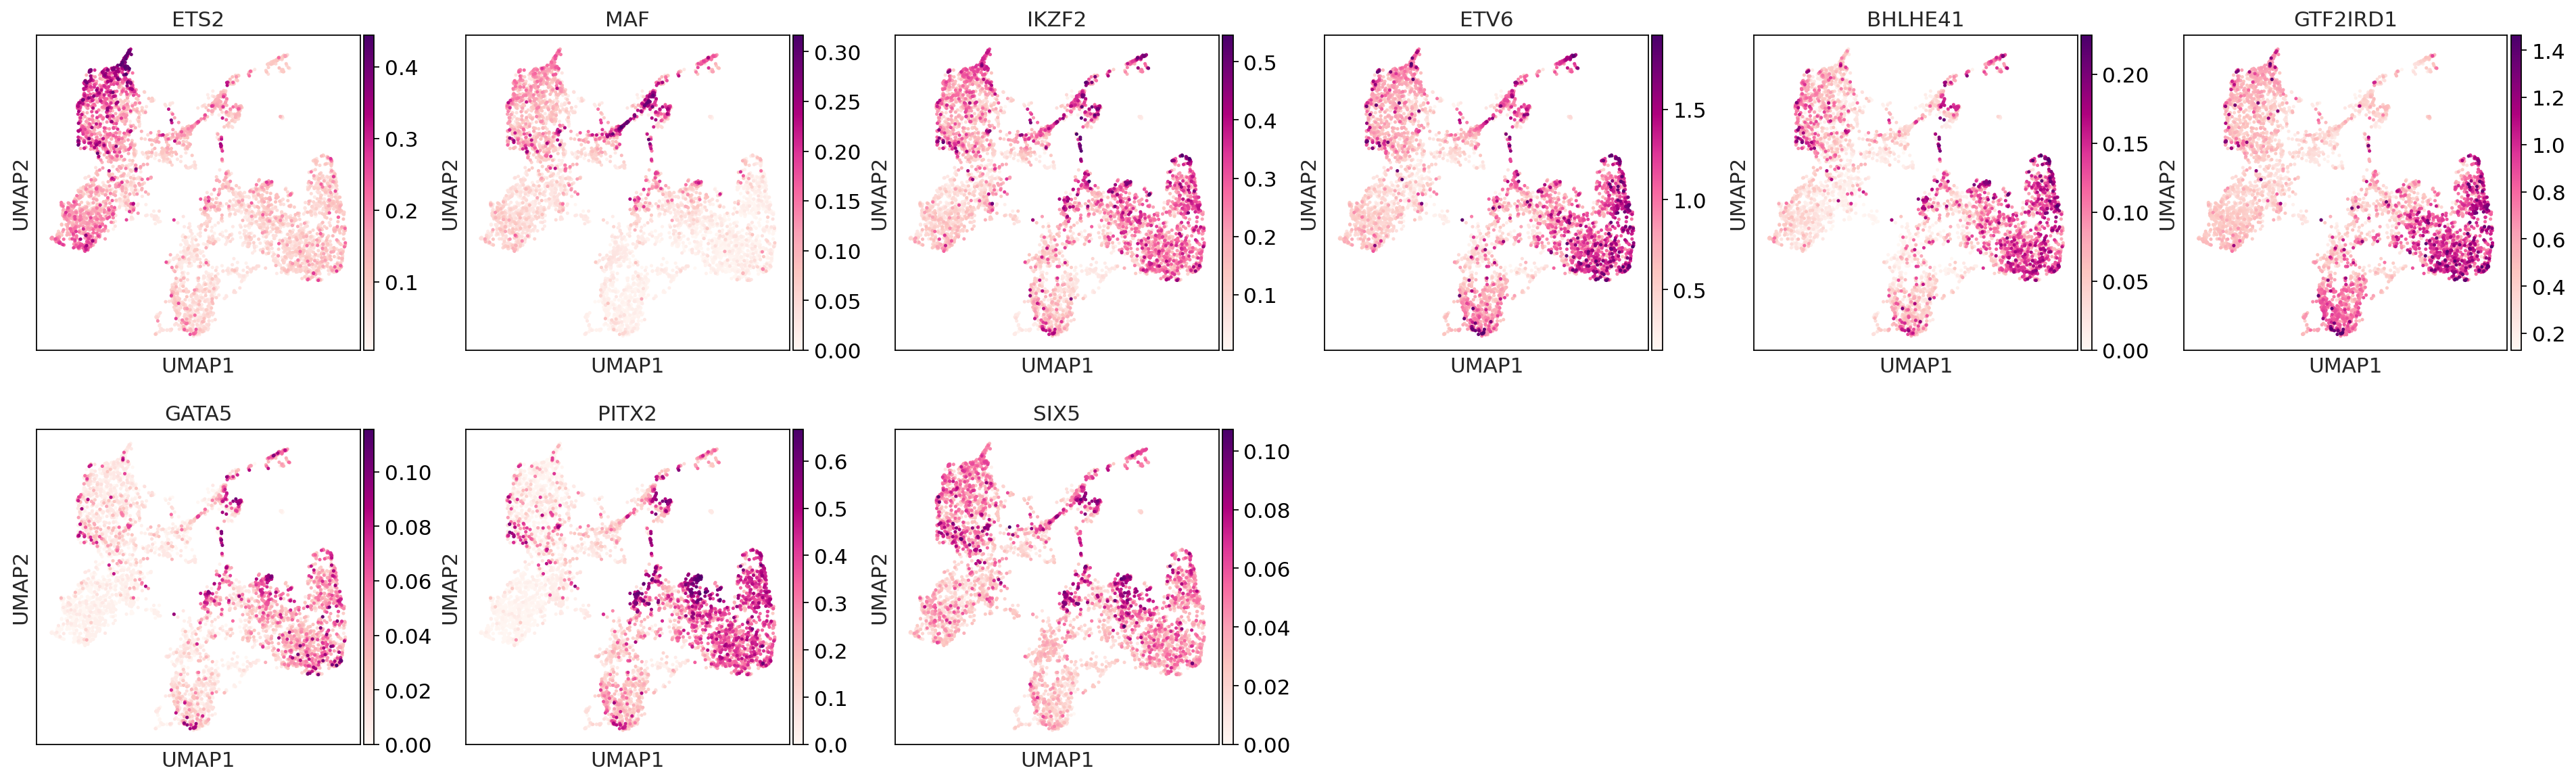

In [12]:
# Check gene expressions
# will be saved to a separated file
sc.settings.set_figure_params(dpi=80)
sc.pl.umap(oracle.adata, color=list_of_TFs, ncols=6,
                 layer="imputed_count", use_raw=False, cmap="RdPu",
                 # show=False, save='_TF_expression.png'
                )

# Set parameters

In [13]:
n_grid = 40
n_neighbors = 100
min_mass = 10
scale_simulation = 5

# Calculating pseudotime gradient vectors

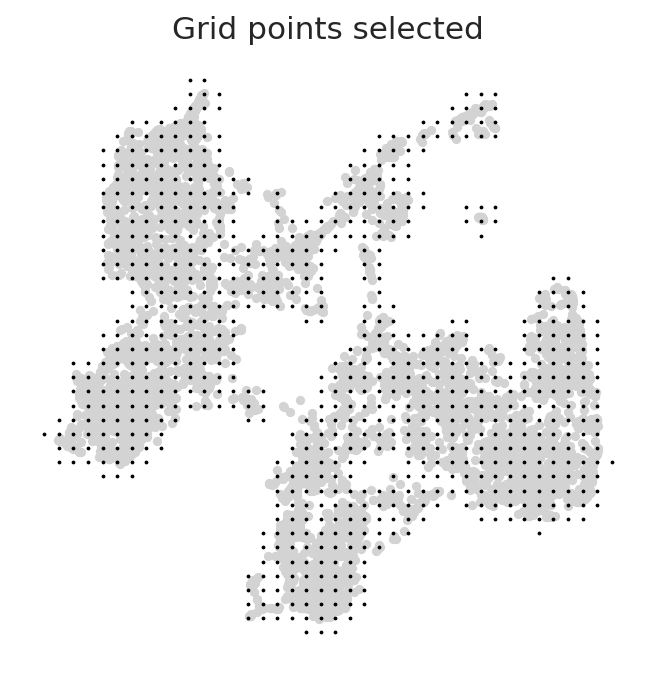

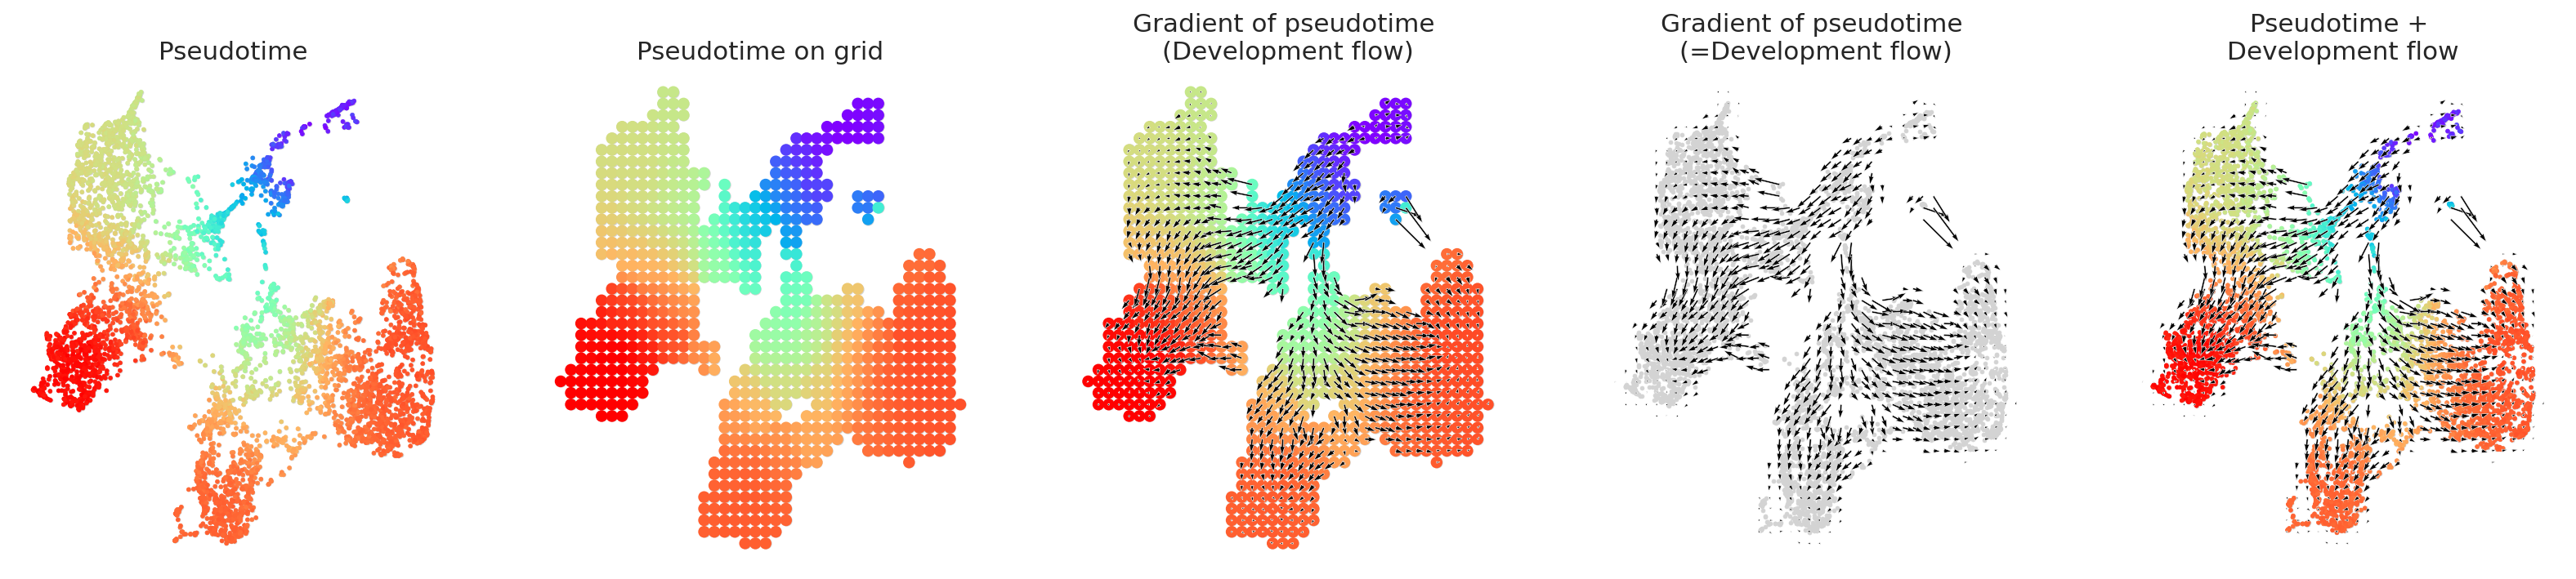

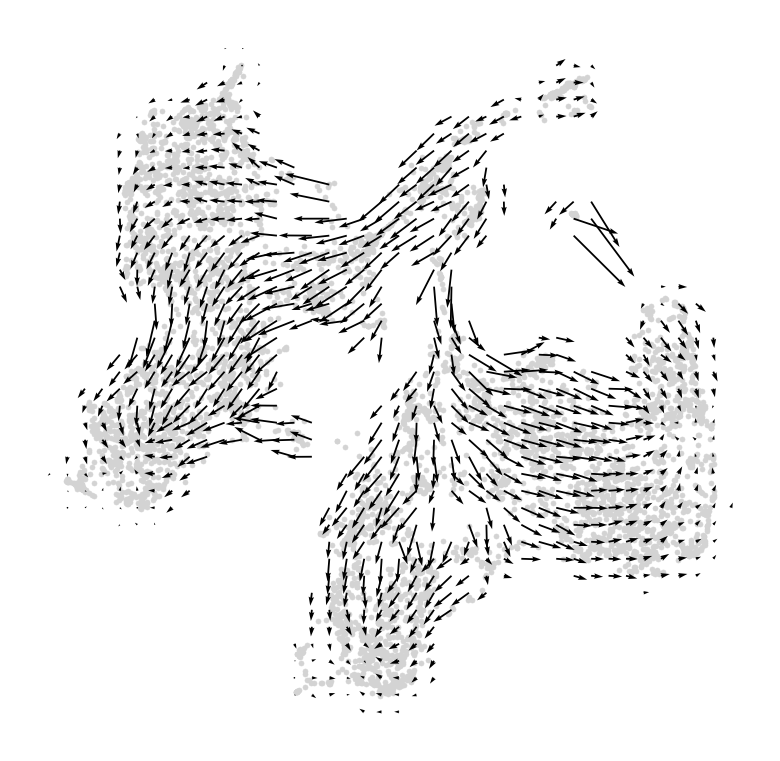

In [14]:
from celloracle.applications import Gradient_calculator
# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="t")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=n_neighbors)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

# convert the pseudotime data into grid points.
# For this calculation we can chose one of two methods.
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

# Calculate graddient
gradient.calculate_gradient()
# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

# Perturbation

In [15]:
from tqdm import tqdm

In [16]:
from celloracle.applications import Oracle_development_module

# not showing plots
matplotlib.use('Agg')

dev_dict = {}
for goi in tqdm(list_of_TFs):
    # Enter perturbation conditions to simulate signal propagation after the perturbation.
    try:
        oracle.simulate_shift(perturb_condition={goi: 0.0}, # this is KO simulation so expression=0
                          n_propagation=3)
        print(f'simulating {goi}')
    except:
        print(f'skipping {goi} due to an error')
        continue
    
    # Get transition probability
    oracle.estimate_transition_prob(n_neighbors=n_neighbors,
                                    knn_random=True,
                                    sampled_fraction=1)

    # Calculate embedding
    oracle.calculate_embedding_shift(sigma_corr=0.05)
    
    # prepare grid
    oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=n_neighbors)
    oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
    
    # plot vector field
    fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
    # Show quiver plot
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
    ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
    # Show quiver plot that was calculated with randomized graph.
    oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
    ax[1].set_title(f"Randomized simulation vector")
    plt.savefig(f'{path_to_plots}/{goi}_simulation_vector.pdf')
    
    # Plot vector field with cell cluster
    fig, ax = plt.subplots(figsize=[8, 8])
    oracle.plot_cluster_whole(ax=ax, s=10)
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)
    plt.savefig(f'{path_to_plots}/{goi}_simulation_vector_with-clusters.pdf')
    
    
    dev = Oracle_development_module()
    # Load development flow
    dev.load_differentiation_reference_data(gradient_object=gradient)

    # Load simulation result
    dev.load_perturb_simulation_data(oracle_object=oracle,
                                     cell_idx_use=None, # Enter cell id list
                                     name=cell_group_name # Name of this cell group. You can enter any name.
                                     )

    # Calculation
    dev.calculate_inner_product()
    dev.calculate_digitized_ip(n_bins=10)
    
    # save to the dictionary
    dev_dict[goi] = dev.copy()
    
    # Let's visualize the results
    vm = 0.01
    dev.visualize_development_module_layout_0(s=5,
                                              scale_for_simulation=scale_simulation,
                                              s_grid=50,
                                              scale_for_pseudotime=scale_dev,
                                              vm=vm)
    plt.savefig(f'{path_to_plots}/{goi}_results.pdf')

  0%|          | 0/9 [00:00<?, ?it/s]

simulating ETS2


2025-05-12 11:57:36,089 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 11:57:36,112 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 11%|█         | 1/9 [05:46<46:14, 346.82s/it]

simulating MAF


2025-05-12 12:03:27,557 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:03:27,574 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 22%|██▏       | 2/9 [11:38<40:46, 349.51s/it]

simulating IKZF2


2025-05-12 12:09:36,927 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:09:36,939 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 33%|███▎      | 3/9 [17:47<35:51, 358.54s/it]

simulating ETV6


2025-05-12 12:15:33,121 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:15:33,139 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 44%|████▍     | 4/9 [23:43<29:48, 357.62s/it]

simulating BHLHE41


2025-05-12 12:21:18,159 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:21:18,185 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 56%|█████▌    | 5/9 [29:29<23:32, 353.20s/it]

simulating GTF2IRD1


2025-05-12 12:27:09,019 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:27:09,033 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 67%|██████▋   | 6/9 [35:19<17:36, 352.29s/it]

simulating GATA5


2025-05-12 12:31:14,606 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:31:14,617 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 78%|███████▊  | 7/9 [39:25<10:34, 317.39s/it]

simulating PITX2


2025-05-12 12:35:16,104 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:35:16,115 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
 89%|████████▉ | 8/9 [43:26<04:53, 293.21s/it]

simulating SIX5


2025-05-12 12:39:20,904 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 12:39:20,928 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
100%|██████████| 9/9 [47:31<00:00, 316.84s/it]


In [17]:
# save
utils.save_pkl(dev_dict, path_to_res_dict)